# Convergence analysis of a FE solution

## Main theoretical results on the convergence of the finite element solution
Consider the variational problem: Find a *trial function* $u\in V$, $u=\bar u$ on $\partial_u\Omega$, such that for each *test function* in $v\in V$, $v=0$ on $\partial_u\Omega$:  

$$
a(u,v) = \ell(v)
$$

where $a$ is a symmetric positive definite form and $\ell$ a linear form. 

We use the following notation (we consider here the 1d case for the sake of simplicity):
- Potential energy of the system 
$$\mathcal{E}(u)=\dfrac{1}{2}a(u,u)-\ell(u)$$

- $u_{FE}$: Finite element solution


- $u_{EX}$: Exact solution 


- $e = u_{FE}-u_{EX}$: Error


- $\Vert u\Vert_{2}:=\sqrt{\int_\Omega u\cdot u\,\mathrm{d}x}$, $L_2$ norm of a function


- $\Vert u\Vert_{H_1}:=\sqrt{\int_\Omega  u'\cdot  u'\,\mathrm{d}x} +\sqrt{\int_\Omega u\cdot u\,\mathrm{d}x}$ , $H_1$ norm of a function


- $\Vert u\Vert_{\infty}:=\sup_{x\in\Omega} u(x)$, sup norm of a function

- $h$ mesh size, $N$ number of dof.


The following fundamental results holds:

1. The solution of the problem is **unique**

2. The **error is orthogonal to the space** $V$
$$a(e,v)=0,\; \forall v\in V$$
3. The **finite element solution minimizes the error in the energy norm** 

4. The square of the energy norm of the error is the error in the potential energy:

$$
\Vert u_{FE}-u_{EX} \Vert_E^2 = \mathcal{E}(u_{FE})-\mathcal{E}(u_{EX})
$$



### Error estimators

It it possible to show that, if the solution is smooth the sup norm of error of the finite element solution is approximate by the norm of the second derivative of the solution
$$\Vert u_{FE} - u_{EX} \Vert_\infty \leq \frac{h^2}{8} \Vert u'' \Vert_\infty $$
This kind of results are based on Taylor expansion estimates of the error of polynomial interpolant of the exact solution and that the FE solution is the best polynomial function to approximate the solution.

Also, we have this other fundamental result, which holds asymptotically for suffienctly large number of dof $N$:

$$\Vert u_{FE} - u_{EX} \Vert_E\sim\frac{ c} {\vert N \vert^\beta} $$

where $\beta$ is the **convergence rate**. For Lagrange element, **$\beta$ should coincide with the polynomial order of the basis functions.**

The formula above is fundamental. In logarithmic form it reads as

\begin{equation} \log{\Vert u_{FE} - u_{EX} \Vert_E} \sim \log{ c} - \beta \log N \end{equation}

giving an easy way to identify from numerical experiments the convergence rate by the slope in log-log diagrams of the error as a function of the number of dof. 

A clear issue is that in most of the problem the exact solution is not available for comparisons. 


In practice one can estimate the convergence rate by using as reference the solution obtained on a very fine mesh, instead of the exact solution. 

A more consistent way of proceeding is based on the following relation

$$
\mathcal{E}(u_N)-\mathcal{E}(u_{EX})=\frac{c^2}{N^{2\beta}}
\quad\Rightarrow\quad  
\frac{\mathcal{E}(u_N)-\mathcal{E}(u_{EX})}{\mathcal{E}(u_{M})-\mathcal{E}(u_{EX})}= \left(\frac{M}{N}\right)^{2\beta}
$$


# Example of convergence analysis

In [1]:
%matplotlib inline
from fenics import *
parameters["plotting_backend"] = 'matplotlib'
import matplotlib.pyplot as plt

RuntimeError: Parameter plotting_backend not found in Parameters object

### A poisson problem
We consider a simple Poisson euqation on a rectangle and we use the method of manufactured solution to have a problem with a knwon non-trivial exact solution (see FEniCS Tutorial)

In [ ]:
# Create mesh and define function space
mesh = UnitSquareMesh(32, 32)
V = FunctionSpace(mesh, "Lagrange", 1)

# Define Dirichlet boundary (x = 0 or x = 1)
def boundary(x, on_boundary):
    return on_boundary

# Define boundary condition
u0 = Constant(0.0)
bc = DirichletBC(V, u0, boundary)

# Define rhs using Expression or symbolic expression
x = SpatialCoordinate(mesh)
f = (2.0*pi**2) * sin(pi*x[0]) * sin(pi*x[1])
#f = Expression("2.0*DOLFIN_PI*DOLFIN_PI*sin(DOLFIN_PI*x[0])*sin(DOLFIN_PI*x[1])", degree=4)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
a = inner(grad(u), grad(v))*dx
L = f*v*dx(degree=4)  # Note specification of quadrature degree for integration

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Save solution in VTK format
file = File("poisson.pvd")
file << u

# Plot solution
plot(u)
plt.show()

### Convergence analysis

In [3]:
import pylab as p

def solve_poisson(q, n):

    # Create mesh and define function space
    mesh = UnitSquareMesh(n, n)
    V = FunctionSpace(mesh, "Lagrange", q)

    # Print size of system
    N = V.dim()
    print("n = %d num_dofs = %d" % (n, N))

    # Define Dirichlet boundary (x = 0 or x = 1)
    def boundary(x, on_boundary):
        return on_boundary

    # Define boundary condition
    u0 = Constant(0.0)
    bc = DirichletBC(V, u0, boundary)

    # Define variational problem
    u = TrialFunction(V)
    v = TestFunction(V)
    f = Expression("2.0*DOLFIN_PI*DOLFIN_PI*sin(DOLFIN_PI*x[0])*sin(DOLFIN_PI*x[1])",
            degree=4)
    a = inner(grad(u), grad(v))*dx
    L = f*v*dx

    # Compute solution
    u = Function(V)
    solve(a == L, u, bc)

    # Compute error
    u_exact = Expression("sin(DOLFIN_PI*x[0])*sin(DOLFIN_PI*x[1])", degree=4)
    error = errornorm(u_exact, u, degree_rise=2, norm_type = "H1")

    return 1.0 / n, N, error

# Check convergence
h1, N1, e1 = zip(*[solve_poisson(1, n) for n in [2, 4, 8, 16, 32, 64, 128, 256]])
h2, N2, e2 = zip(*[solve_poisson(2, n) for n in [2, 4, 8, 16, 32, 64, 128, 256]])

def fmt(values):
    return "  ".join("%.4e" % v for v in values)
print("Convergence:")
print("h1:", fmt(h1))
print("h2:", fmt(h2))
print("N1:", fmt(N1))
print("N2:", fmt(N2))
print("e1:", fmt(e1))
print("e2:", fmt(e2))



n = 2 num_dofs = 9
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
n = 4 num_dofs = 25
n = 8 num_dofs = 81
n = 16 num_dofs = 289
n = 32 num_dofs = 1089
n = 64 num_dofs = 4225
n = 128 num_dofs = 16641
n = 256 num_dofs = 66049
Calling FFC just-in-time (JIT) compiler, this may take some time.
n = 2 num_dofs = 25
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
n = 4 num_dofs = 81
n = 8 num_dofs = 289
n = 16 num_dofs = 1089
n = 32 num_dofs = 4225
n = 64 num_dofs = 16641
n = 128 num_dofs = 66049
n = 256

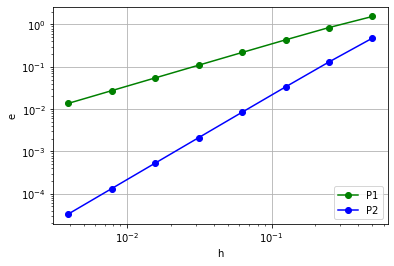

In [5]:
# Plot results
enable_plot = True
if enable_plot:
    p.loglog(h1, e1, 'g-o')
    p.loglog(h2, e2, 'b-o')
    p.legend(["P1", "P2"], loc="lower right")
    p.xlabel("h")
    p.ylabel("e")
    p.grid(True)
    p.show()

Look at the following Section of the FEniCS tutorial for further details:
 * [5.5 Postprocessing computations](https://fenicsproject.org/pub/tutorial/html/._ftut1020.html#ch:poisson0:convrates)